<a href="https://practicalai.me"><img src="https://raw.githubusercontent.com/practicalAI/images/master/images/rounded_logo.png" width="100" align="left" hspace="20px" vspace="20px"></a>

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/04_Linear_Regression/linear_regression.png" width="150" vspace="20px" align="right">

<div align="left">
<h1>Linear Regression</h1>

In this lesson we will learn about linear regression. We will understand the basic math behind it, implement it in Python. and then look at ways of interpreting the linear model.
</div>

<table align="center">
  <td>
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/rounded_logo.png" width="25"><a target="_blank" href="https://practicalai.me"> View on practicalAI</a>
  </td>
  <td>
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/colab_logo.png" width="25"><a target="_blank" href="https://colab.research.google.com/github/practicalAI/practicalAI/blob/master/notebooks/04_Linear_Regression.ipynb"> Run in Google Colab</a>
  </td>
  <td>
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/github_logo.png" width="22"><a target="_blank" href="https://github.com/practicalAI/practicalAI/blob/master/notebooks/basic_ml/04_Linear_Regression.ipynb"> View code on GitHub</a>
  </td>
</table>

# Overview

Our goal is to learn a linear model $\hat{y}$ that models $y$ given $X$. 

$\hat{y} = XW + b$
* $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DX1}$ 
* $b$ = bias | $\in \mathbb{R}^{1}$ 

* **Objective:**  Use inputs $X$ to predict the output $\hat{y}$ using a linear model. The model will be a line of best fit that minimizes the distance between the predicted (model's output) and target (ground truth) values. Training data $(X, y)$ is used to train the model and learn the weights $W$ using gradient descent.
* **Advantages:**
  * Computationally simple.
  * Highly interpretable.
  * Can account for continuous and categorical features.
* **Disadvantages:**
  * The model will perform well only when the data is linearly separable (for classification).
  * Usually not used for classification and only for regression.
* **Miscellaneous:** You can also use linear regression for binary classification tasks where if the predicted continuous value is above a threshold, it belongs to a certain class. But we will cover better techniques for classification in future lessons and will focus on linear regression for continuous regression tasks only.


### Training

1. Randomly initialize the model's weights $W$ (we'll cover more effective initialization strategies in future lessons).
2. Feed inputs $X$ into the model to receive the predictions $\hat{y}$.
  * $\hat{y} = XW + b$
3. Compare the predictions $\hat{y}$ with the actual target values $y$ using the objective (cost) function to determine the loss $J$. A common objective function for linear regression is mean squarred error (MSE). This function calculates the difference between the predicted and target values and squares it.

  * $J(\theta) = MSE = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2 $
    * ${y}$ = ground truth | $\in \mathbb{R}^{NX1}$
    * $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$
4. Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights.
  * $J(\theta) = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2  = \frac{1}{N}\sum_i (y_i - X_iW)^2 $
    * $\frac{\partial{J}}{\partial{W}} = -\frac{2}{N} \sum_i (y_i - X_iW) X_i = -\frac{2}{N} \sum_i (y_i - \hat{y}_i) X_i$
    * $\frac{\partial{J}}{\partial{b}} = -\frac{2}{N} \sum_i (y_i - X_iW)1 = -\frac{2}{N} \sum_i (y_i - \hat{y}_i)1$
5. Update the weights $W$ using a small learning rate $\alpha$. The simplified intuition is that the gradient tells you the direction for how to increase something so subtracting it will help you go the other way since we want to decrease loss $J(\theta)$:
  * $W = W - \alpha\frac{\partial{J}}{\partial{W}}$
  * $b = b - \alpha\frac{\partial{J}}{\partial{b}}$
6. Repeat steps 2 - 5 to minimize the loss and train the model.

# Set up

In [1]:
# Use TensorFlow 2.x
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import numpy as np
import tensorflow as tf

In [0]:
# Arguments
SEED = 1234
SHUFFLE = True
NUM_SAMPLES = 50
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
NUM_EPOCHS = 100
BATCH_SIZE = 10
INPUT_DIM = 1
HIDDEN_DIM = 1
LEARNING_RATE = 1e-1

In [0]:
# Set seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Data

We're going to create some simple dummy data to apply linear regression on.

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

### Components

We're going to create some dummy data to train our linear regression model on. We're going to create roughly linear data (`y = 3.5X + 10`) with some random noise so the points don't all align in a straight line. Our goal is to have the model converge to a similar linear equation (there will be slight variance since we added some noise).

In [0]:
# Generate synthetic data
def generate_data(num_samples):
    """Generate dummy data for linear regression."""
    X = np.array(range(num_samples))
    random_noise = np.random.uniform(-10,20,size=num_samples)
    y = 3.5*X + random_noise # add some noise
    return X, y

### Operations

Now let's load the data onto a dataframe and visualize it.

In [7]:
# Generate random (linear) data
X, y = generate_data(num_samples=NUM_SAMPLES)
data = np.vstack([X, y]).T
df = pd.DataFrame(data, columns=['X', 'y'])
X = df[['X']].values
y = df[['y']].values
df.head()

,X,y
0,0.0,-4.254416
1,1.0,12.163263
2,2.0,10.131832
3,3.0,24.060758
4,4.0,27.399274


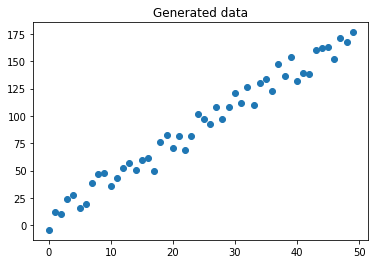

In [8]:
# Scatter plot
plt.title("Generated data")
plt.scatter(x=df['X'], y=df['y'])
plt.show()

# Split data



In [0]:
from sklearn.model_selection import train_test_split

### Components

Since our task is a regression task, we will randomly split our dataset into **three** sets: train, validation and test data splits.

* train: used to train our model.
* val : used to validate our model's performance during training.
* test: used to do an evaluation of our fully trained model.

<div align="left">
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/lightbulb.gif" width="45px" align="left" hspace="10px">
</div>
Splitting the data for classification tasks are a bit different in that we want similar class distributions in each data split. We'll see this in action in the next lesson.

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

### Operations

In [11]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_test: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"X_train[0]: {X_train[0]}")
print (f"y_train[0]: {y_train[0]}")

X_train: (35, 1), y_train: (35, 1)
X_val: (7, 1), y_test: (7, 1)
X_test: (8, 1), y_test: (8, 1)
X_train[0]: [12.]
y_train[0]: [52.50388806]


# Standardize data

We need to standardize our data (zero mean and unit variance) in order to optimize quickly.

$z = \frac{x_i - \mu}{\sigma}$
* $z$ = standardized value
* $x_i$ = inputs
* $\mu$ = mean
* $\sigma$ = standard deviation

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [0]:
# Apply scaler on training and test data
standardized_X_train = X_scaler.transform(X_train)
standardized_y_train = y_scaler.transform(y_train).ravel()
standardized_X_val = X_scaler.transform(X_val)
standardized_y_val = y_scaler.transform(y_val).ravel()
standardized_X_test = X_scaler.transform(X_test)
standardized_y_test = y_scaler.transform(y_test).ravel()

In [15]:
# Check (means should be ~0 and std should be ~1)
print (f"standardized_X_train: mean: {np.mean(standardized_X_train, axis=0)[0]}, std: {np.std(standardized_X_train, axis=0)[0]}")
print (f"standardized_y_train: mean: {np.mean(standardized_y_train, axis=0)}, std: {np.std(standardized_y_train, axis=0)}")
print (f"standardized_X_val: mean: {np.mean(standardized_X_val, axis=0)[0]}, std: {np.std(standardized_X_val, axis=0)[0]}")
print (f"standardized_y_val: mean: {np.mean(standardized_y_val, axis=0)}, std: {np.std(standardized_y_val, axis=0)}")
print (f"standardized_X_test: mean: {np.mean(standardized_X_test, axis=0)[0]}, std: {np.std(standardized_X_test, axis=0)[0]}")
print (f"standardized_y_test: mean: {np.mean(standardized_y_test, axis=0)}, std: {np.std(standardized_y_test, axis=0)}")

standardized_X_train: mean: -1.2688263138573217e-16, std: 1.0
standardized_y_train: mean: 8.961085841617335e-17, std: 1.0
standardized_X_val: mean: 0.455275148918323, std: 0.8941749819083381
standardized_y_val: mean: 0.48468545395300805, std: 0.9785039908565315
standardized_X_test: mean: -0.44282621906508784, std: 1.0652341142978086
standardized_y_test: mean: -0.4940327711822252, std: 1.0650188983159736


# From scratch

Before we use TensorFlow 2.0 + Keras we will implement linear regression from scratch using NumPy so we can:
1. Absorb the fundamental concepts by implementing from scratch
2. Appreciate the level of abstraction TensorFlow provides

<div align="left">
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/lightbulb.gif" width="45px" align="left" hspace="10px">
</div>

It's normal to find the math and code in this section slightly complex. You can still read each of the steps to build intuition for when we implement this using TensorFlow + Keras.

In [16]:
standardized_y_train = standardized_y_train.reshape(-1, 1)
print (f"X: {standardized_X_train.shape}")
print (f"y: {standardized_y_train.shape}")

X: (35, 1)
y: (35, 1)


Our goal is to learn a linear model $\hat{y}$ that models $y$ given $X$. 

$\hat{y} = XW + b$
* $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DX1}$ 
* $b$ = bias | $\in \mathbb{R}^{1}$ 

1.   Randomly initialize the model's weights $W$.

In [17]:
# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, 1)
b = np.zeros((1, 1))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (1, 1)
b: (1, 1)


2. Feed inputs $X$ into the model to receive the predictions $\hat{y}$.
  * $\hat{y} = XW + b$

In [18]:
# Forward pass [NX1] · [1X1] = [NX1]
y_hat = np.dot(standardized_X_train, W) + b
print (f"y_hat: {y_hat.shape}")

y_hat: (35, 1)


3. Compare the predictions $\hat{y}$ with the actual target values $y$ using the objective (cost) function to determine the loss $J$. A common objective function for linear regression is mean squarred error (MSE). This function calculates the difference between the predicted and target values and squares it.

  * $J(\theta) = MSE = \frac{1}{N} \sum_{i-1}^{N} (y_i - \hat{y}_i)^2 $
    * ${y}$ = ground truth | $\in \mathbb{R}^{NX1}$
    * $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$

In [19]:
# Loss
N = len(standardized_y_train)
loss = (1/N) * np.sum((standardized_y_train - y_hat)**2)
print (f"loss: {loss:.2f}")

loss: 1.02


4. Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights.
  * $J(\theta) = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2  = \frac{1}{N}\sum_i (y_i - X_iW)^2 $
    * $\frac{\partial{J}}{\partial{W}} = -\frac{2}{N} \sum_i (y_i - X_iW) X_i = -\frac{2}{N} \sum_i (y_i - \hat{y}_i) X_i$
    * $\frac{\partial{J}}{\partial{W}} = -\frac{2}{N} \sum_i (y_i - X_iW)1 = -\frac{2}{N} \sum_i (y_i - \hat{y}_i)1$

In [0]:
# Backpropagation
dW = -(2/N) * np.sum((standardized_y_train - y_hat) * standardized_X_train)
db = -(2/N) * np.sum((standardized_y_train - y_hat) * 1)

5. Update the weights $W$ using a small learning rate $\alpha$. The simplified intuition is that the gradient tells you the direction for how to increase something so subtracting it will help you go the other way since we want to decrease loss $J(\theta)$:
  * $W = W - \alpha\frac{\partial{J}}{\partial{W}}$
  * $b = b - \alpha\frac{\partial{J}}{\partial{b}}$

In [0]:
# Update weights
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db

6. Repeat steps 2 - 5 to minimize the loss and train the model.

In [22]:
# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, 1)
b = np.zeros((1, ))

# Training loop
for epoch_num in range(NUM_EPOCHS):

    # Forward pass [NX1] · [1X1] = [NX1]
    y_hat = np.dot(standardized_X_train, W) + b

    # Loss
    loss = (1/len(standardized_y_train)) * np.sum((standardized_y_train - y_hat)**2)

    # show progress
    if epoch_num%10 == 0:
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}")

    # Backpropagation
    dW = -(2/N) * np.sum((standardized_y_train - y_hat) * standardized_X_train)
    db = -(2/N) * np.sum((standardized_y_train - y_hat) * 1)

    # Update weights
    W += -LEARNING_RATE * dW
    b += -LEARNING_RATE * db

Epoch: 0, loss: 1.025
Epoch: 10, loss: 0.040
Epoch: 20, loss: 0.028
Epoch: 30, loss: 0.028
Epoch: 40, loss: 0.028
Epoch: 50, loss: 0.028
Epoch: 60, loss: 0.028
Epoch: 70, loss: 0.028
Epoch: 80, loss: 0.028
Epoch: 90, loss: 0.028


In [0]:
# Predictions 
pred_train = W*standardized_X_train + b
pred_test = W*standardized_X_test + b

In [24]:
# Train and test MSE
train_mse = np.mean((standardized_y_train - pred_train) ** 2)
test_mse = np.mean((standardized_y_test - pred_test) ** 2)
print (f"train_MSE: {train_mse:.2f}, test_MSE: {test_mse:.2f}")

train_MSE: 0.03, test_MSE: 2.24


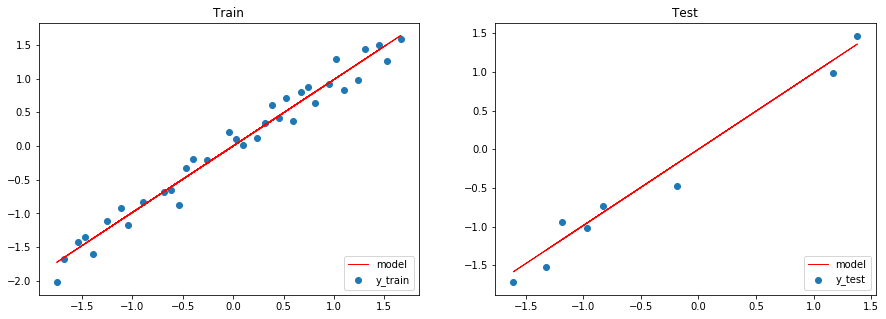

In [25]:
# Figure size
plt.figure(figsize=(15,5))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(standardized_X_train, standardized_y_train, label='y_train')
plt.plot(standardized_X_train, pred_train, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(standardized_X_test, standardized_y_test, label='y_test')
plt.plot(standardized_X_test, pred_test, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Show plots
plt.show()

Since we standardized our inputs and outputs, our weights were fit to those standardized values. So we need to unstandardize our weights so we can compare it to our true weight (3.5).

Note that both X and y were standardized.

$\hat{y}_{scaled} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}x_{{scaled}_j}$
* $y_{scaled} = \frac{\hat{y} - \bar{y}}{\sigma_y}$
* $x_{scaled} = \frac{x_j - \bar{x}_j}{\sigma_j}$

$\frac{\hat{y} - \bar{y}}{\sigma_y} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}\frac{x_j - \bar{x}_j}{\sigma_j}$

$ \hat{y}_{scaled} = \frac{\hat{y}_{unscaled} - \bar{y}}{\sigma_y} = {b_{scaled}} + \sum_{j=1}^{k} {W}_{{scaled}_j} (\frac{x_j - \bar{x}_j}{\sigma_j}) $

$\hat{y}_{unscaled} = b_{scaled}\sigma_y + \bar{y} - \sum_{j=1}^{k} {W}_{{scaled}_j}(\frac{\sigma_y}{\sigma_j})\bar{x}_j + \sum_{j=1}^{k}{W}_{{scaled}_j}(\frac{\sigma_y}{\sigma_j})x_j $

In the expression above, we can see the expression $\hat{y}_{unscaled} = W_{unscaled}x + b_{unscaled} $ where

* $W_{unscaled} = \sum_{j=1}^{k}{W}_j(\frac{\sigma_y}{\sigma_j}) $

* $b_{unscaled} = b_{scaled}\sigma_y + \bar{y} - \sum_{j=1}^{k} {W}_j(\frac{\sigma_y}{\sigma_j})\bar{x}_j$





In [26]:
# Unscaled weights
W_unscaled = W * (y_scaler.scale_/X_scaler.scale_)
b_unscaled = b * y_scaler.scale_ + y_scaler.mean_ - np.sum(W_unscaled*X_scaler.mean_)
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled[0][0]:.1f}X + {b_unscaled[0]:.1f}") 

[actual] y = 3.5X + noise
[model] y_hat = 3.4X + 9.5


Now let's implement linear regression with TensorFlow + Keras.

# TensorFlow + Keras

We will be using [Dense layers](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense) in our MLP implementation. The layer applies an activation function on the dot product of the layer's inputs and its weights.

$ z = \text{activation}(XW)$

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

In [28]:
x = Input(shape=(INPUT_DIM,))
fc = Dense(units=HIDDEN_DIM, activation='linear')
z = fc(x)
W, b = fc.weights
print (f"z {z.shape} = x {x.shape} · W {W.shape} + b {b.shape}")

z (None, 1) = x (None, 1) · W (1, 1) + b (1,)


# Model

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [0]:
# Linear regression
class LinearRegression(Model):
    def __init__(self, hidden_dim):
        super(LinearRegression, self).__init__()
        self.fc1 = Dense(units=hidden_dim, activation='linear')
        
    def call(self, x_in, training=False):
        """Forward pass."""
        y_pred = self.fc1(x_in)
        return y_pred
    
    def sample(self, input_shape):
        x_in = Input(shape=input_shape)
        return Model(inputs=x_in, outputs=self.call(x_in)).summary()

In [31]:
# Initialize the model
model = LinearRegression(hidden_dim=HIDDEN_DIM)
model.sample(input_shape=(INPUT_DIM,))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


When we implemented linear regression from scratch, we used batch gradient descent to update our weights. But there are actually many different [gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/) to choose from and it depends on the situation. However, the [ADAM optimizer](https://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms/#adam) has become a standard algorithm for most cases. 

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=MeanSquaredError(),
              metrics=[MeanAbsolutePercentageError()])

<img height="45" src="http://bestanimations.com/HomeOffice/Lights/Bulbs/animated-light-bulb-gif-29.gif" align="left" vspace="5px" hspace="10px">

Here are the full list of options for [optimizer](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers), [loss](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses) and [metrics](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics).

# Training

When we implemented linear regression from scratch, we used batch gradient descent to update our weights. This means that we calculated the gradients using the entire training dataset. We also could've updated our weights using stochastic gradient descent (SGD) where we pass in one training example at a time. The current standard is mini-batch gradient descent, which strikes a balance between batch and stochastic GD, where we update the weights using a mini-batch of n (`BATCH_SIZE`) samples.

In [33]:
# Training
model.fit(x=standardized_X_train, 
          y=standardized_y_train,
          validation_data=(standardized_X_val, standardized_y_val),
          epochs=NUM_EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=False,
          verbose=1)

Train on 35 samples, validate on 7 samples
Epoch 1/100
35/35 [==============================] - 1s 29ms/sample - loss: 2.2303 - mean_absolute_percentage_error: 189.2383 - val_loss: 1.8631 - val_mean_absolute_percentage_error: 110.1029
Epoch 2/100
35/35 [==============================] - 0s 604us/sample - loss: 1.1683 - mean_absolute_percentage_error: 129.5676 - val_loss: 0.8827 - val_mean_absolute_percentage_error: 85.6471
Epoch 3/100
35/35 [==============================] - 0s 650us/sample - loss: 0.5139 - mean_absolute_percentage_error: 72.2302 - val_loss: 0.3088 - val_mean_absolute_percentage_error: 63.4733
Epoch 4/100
35/35 [==============================] - 0s 675us/sample - loss: 0.1775 - mean_absolute_percentage_error: 58.3600 - val_loss: 0.0744 - val_mean_absolute_percentage_error: 43.0542
Epoch 5/100
35/35 [==============================] - 0s 635us/sample - loss: 0.0590 - mean_absolute_percentage_error: 55.3533 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 29.1076


# Evaluation

There are several evaluation techniques to see how well our model performed. A common one for linear regression is mean squarred error.

In [0]:
# Predictions
pred_train = model.predict(standardized_X_train)
pred_test = model.predict(standardized_X_test)

In [35]:
# Train and test MSE
train_mse = np.mean((standardized_y_train - pred_train) ** 2)
test_mse = np.mean((standardized_y_test - pred_test) ** 2)
print (f"train_MSE: {train_mse:.2f}, test_MSE: {test_mse:.2f}")

train_MSE: 0.03, test_MSE: 2.21


Since we only have one feature, it's easy to visually inspect the model.

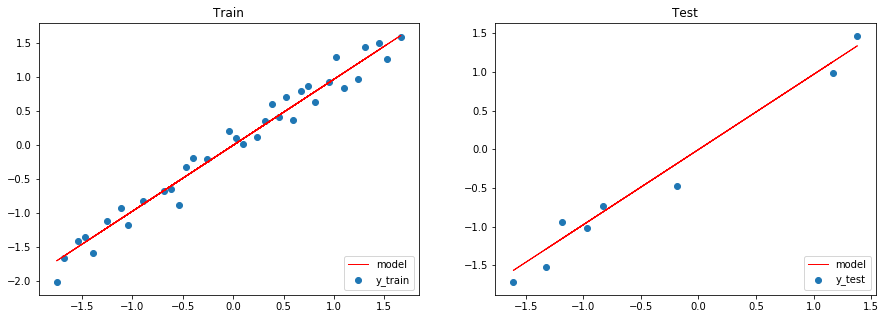

In [36]:
# Figure size
plt.figure(figsize=(15,5))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(standardized_X_train, standardized_y_train, label='y_train')
plt.plot(standardized_X_train, pred_train, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(standardized_X_test, standardized_y_test, label='y_test')
plt.plot(standardized_X_test, pred_test, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Show plots
plt.show()

# Inference

After training a model, we can use it to predict on new data.

In [0]:
# Feed in your own inputs
sample_indices = [10, 15, 25]
X_infer = np.array(sample_indices, dtype=np.float32)
standardized_X_infer = X_scaler.transform(X_infer.reshape(-1, 1))

Recall that we need to unstandardize our predictions.

$ \hat{y}_{scaled} = \frac{\hat{y} - \mu_{\hat{y}}}{\sigma_{\hat{y}}} $

$ \hat{y} = \hat{y}_{scaled} * \sigma_{\hat{y}} + \mu_{\hat{y}} $

In [38]:
# Unstandardize predictions
pred_infer = model.predict(standardized_X_infer) * np.sqrt(y_scaler.var_) + y_scaler.mean_
for i, index in enumerate(sample_indices):
    print (f"{df.iloc[index]['y']:.2f} (actual) → {pred_infer[i][0]:.2f} (predicted)")

35.73 (actual) → 43.49 (predicted)
59.34 (actual) → 60.03 (predicted)
97.04 (actual) → 93.09 (predicted)


# Interpretability

Linear regression offers the great advantage of being highly interpretable. Each feature has a coefficient which signifies its importance/impact on the output variable y. We can interpret our coefficient as follows: by increasing X by 1 unit, we increase y by $W$ (~3.65) units. 

**Note**: Since we standardized our inputs and outputs for gradient descent, we need to apply an operation to our coefficients and intercept to interpret them. See proof in the `From scratch` section above.

In [39]:
# Unstandardize coefficients (proof is in the `From Scratch` section above)
W = model.layers[0].get_weights()[0][0][0]
b = model.layers[0].get_weights()[1][0]
W_unscaled = W * (y_scaler.scale_/X_scaler.scale_)
b_unscaled = b * y_scaler.scale_ + y_scaler.mean_ - np.sum(W_unscaled*X_scaler.mean_)
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled[0]:.1f}X + {b_unscaled[0]:.1f}") 

[actual] y = 3.5X + noise
[model] y_hat = 3.3X + 10.4


# Regularization

Regularization helps decrease overfitting. Below is L2 regularization (ridge regression). There are many forms of regularization but they all work to reduce overfitting in our models. With L2 regularization, we are penalizing the weights with large magnitudes by decaying them. Having certain weights with high magnitudes will lead to preferential bias with the inputs and we want the model to work with all the inputs and not just a select few. There are also other types of regularization like L1 (lasso regression) which is useful for creating sparse models where some feature cofficients are zeroed out, or elastic which combines L1 and L2 penalties. 

**Note**: Regularization is not just for linear regression. You can use it to regularize any model's weights including the ones we will look at in future lessons.

$ J(\theta) = = \frac{1}{2}\sum_{i}(X_iW - y_i)^2 + \frac{\lambda}{2}W^TW$

$ \frac{\partial{J}}{\partial{W}}  = X (\hat{y} - y) + \lambda W $

$W = W- \alpha\frac{\partial{J}}{\partial{W}}$
* $\lambda$ is the regularzation coefficient

In [0]:
from tensorflow.keras.regularizers import l2

In [0]:
L2_LAMBDA = 1e-2

In [0]:
# Linear model with L2 regularization
class LinearRegressionL2Regularization(Model):
    def __init__(self, hidden_dim):
        super(LinearRegressionL2Regularization, self).__init__()
        self.fc1 = Dense(units=hidden_dim, activation='linear',
                        kernel_regularizer=l2(l=L2_LAMBDA))
        
    def call(self, x_in, training=False):
        """Forward pass."""
        y_pred = self.fc1(x_in)
        return y_pred
    
    def sample(self, input_shape):
        x_in = Input(shape=input_shape)
        return Model(inputs=x_in, outputs=self.call(x_in)).summary()

In [43]:
# Initialize the model
model = LinearRegressionL2Regularization(hidden_dim=HIDDEN_DIM)
model.sample(input_shape=(INPUT_DIM,))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=MeanSquaredError(),
              metrics=[MeanAbsolutePercentageError()])

In [45]:
# Training
model.fit(x=standardized_X_train, 
          y=standardized_y_train,
          validation_data=(standardized_X_val, standardized_y_val),
          epochs=NUM_EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=SHUFFLE,
          verbose=1)

Train on 35 samples, validate on 7 samples
Epoch 1/100
35/35 [==============================] - 0s 12ms/sample - loss: 0.3207 - mean_absolute_percentage_error: 63.4316 - val_loss: 0.1373 - val_mean_absolute_percentage_error: 47.1876
Epoch 2/100
35/35 [==============================] - 0s 681us/sample - loss: 0.0765 - mean_absolute_percentage_error: 56.2515 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 25.8445
Epoch 3/100
35/35 [==============================] - 0s 763us/sample - loss: 0.0624 - mean_absolute_percentage_error: 46.6229 - val_loss: 0.0400 - val_mean_absolute_percentage_error: 17.3323
Epoch 4/100
35/35 [==============================] - 0s 764us/sample - loss: 0.0910 - mean_absolute_percentage_error: 46.5634 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 16.3579
Epoch 5/100
35/35 [==============================] - 0s 768us/sample - loss: 0.0680 - mean_absolute_percentage_error: 43.0348 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 20.1073
Epo

In [0]:
# Predictions
pred_train = model.predict(standardized_X_train)
pred_test = model.predict(standardized_X_test)

In [47]:
# Train and test MSE
train_mse = np.mean((standardized_y_train - pred_train) ** 2)
test_mse = np.mean((standardized_y_test - pred_test) ** 2)
print (f"train_MSE: {train_mse:.2f}, test_MSE: {test_mse:.2f}")

train_MSE: 0.03, test_MSE: 2.24


In [48]:
# Unstandardize coefficients (proof is in the `From Scratch` section above)
W = model.layers[0].get_weights()[0][0][0]
b = model.layers[0].get_weights()[1][0]
W_unscaled = W * (y_scaler.scale_/X_scaler.scale_)
b_unscaled = b * y_scaler.scale_ + y_scaler.mean_ - np.sum(W_unscaled*X_scaler.mean_)
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled[0]:.1f}X + {b_unscaled[0]:.1f}") 

[actual] y = 3.5X + noise
[model] y_hat = 3.4X + 9.5


Regularization didn't help much with this specific example because our data is generated from a perfect linear equation but for large realistic data, regularization can help our model generalize well.

# Categorical variables

In our example, the feature was a continuous variable but what if we also have features that are categorical? One option is to treat the categorical variables as one-hot encoded variables. This is very easy to do with Pandas and once you create the dummy variables, you can use the same steps as above to train your linear model.

In [49]:
# Create data with categorical features
cat_data = pd.DataFrame(['a', 'b', 'c', 'a'], columns=['favorite_letter'])
cat_data.head()

,favorite_letter
0,a
1,b
2,c
3,a


In [50]:
dummy_cat_data = pd.get_dummies(cat_data)
dummy_cat_data.head()

,favorite_letter_a,favorite_letter_b,favorite_letter_c
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0


Now you can concat this with your continuous features and train the linear model.

---
<div align="center">

Subscribe to our <a href="https://practicalai.me/#newsletter">newsletter</a> and follow us on social media to get the latest updates!

<a class="ai-header-badge" target="_blank" href="https://github.com/practicalAI/practicalAI">
              <img src="https://img.shields.io/github/stars/practicalAI/practicalAI.svg?style=social&label=Star"></a>&nbsp;
            <a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml">
              <img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
            <a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml">
              <img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social">
            </a>
              </div>

</div>